In [1]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


The recursive Green's function method relies on these two equations:
$$ \check{G}^{L}_{j} = \left[ i\omega_{p} \check{1} - \check{H}^{0}_{j} - \check{T}^{+}_{j}\check{G}^{L}_{j-1} \check{T}^{-}_{j} \right]^{-1} $$
starting at $j = j_{L}$, which is some slice in the left lead,
$$ \check{G}^{R}_{j} = \left[ i\omega_{p} \check{1} - \check{H}^{0}_{j} - \check{T}^{-}_{j+1}\check{G}^{R}_{j+1} \check{T}^{+}_{j + 1} \right]^{-1} $$
starting at $j = j_{R}$ which is some slice in the right lead,
and finally:
$$\check{G}_{\omega_{p}}(j , j) = \left[ i\omega_{p} \check{1} -  \check{H}^{0}_{j} - \check{T}^{-}_{j+1}\check{G}^{R}_{j+1} \check{T}^{+}_{j + 1}  - \check{T}^{+}_{j}\check{G}^{L}_{j-1} \check{T}^{-}_{j} \right] $$
An upside down hat means its a $(2W \times 2W)$ matrix. $\check{T}^{+}_{j}$ is the matrix that shifts you to the right from site $j$, whilst $\check{T}^{-}_{j}$ shifts you to the left from site $j$. Also $\check{G}^{L/R}_{j} = \check{G}_{\omega_{P}}(j , j)$ which is the Green's function of the system in which all alttice site $j'\geq j+1$ and $j' \leq j - 1$ are deleted.
These means we will first have to evaluate $\check{G}^{L}_{j_{L}-1}$ and $\check{G}^{R}_{j_{R} + 1}$, which this paper tells me how to do numerically: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.44.8017. Probably best to evaluate this numerically since these Green's functions are only analytically soluble in the simplest of cases (i.e. s-wave disorderless superconductors).


From the Ando paper I learned that I should first calculate all modes in the ideal superconducting leads. This should give me a matrix of eigenvectors $U(\pm)$ (where $+$ corresponds to right moving and $-$ corresponds to left-moving) and a diagonal matrix of eigenvalues $\Lambda(\pm)$. We can determine whether they are rightr movers or left movers by studying $arg(\Lambda_{ii})$. The important matrix to calculate is:
$$ F(-) = U(-)\Lambda(-)U^{-1}(-)$$ 

To compute all the modes in the lead, I need to solve the following eigenvalue problem:
$$ \underbrace{\begin{pmatrix} - [\check{T}^{-}]^{-1}(\check{H}^{j}_0 - E) & -[\check{T}^{-}]^{-1}\check{T}^{+} \\ \check{1} & \check{0} \end{pmatrix}}_{\mathbb{M}}\begin{pmatrix}\vec{c}_{j} \\ \vec{c}_{j-1} \end{pmatrix} = \lambda \begin{pmatrix}\vec{c}_{j} \\ \vec{c}_{j-1} \end{pmatrix} $$
where $\check{H}^{j}_{0}$ is the onsite Hamiltonian of slice $j$ and $\vec{c}_{j}$ is the vector of amplitudes on slice $j$. The argument of $\lambda$ will give the direction of current between slice $j -1$ and slice $j$.

In [2]:
from dataclasses import dataclass
from RGFtools import *
@dataclass
class JosephsonParameters:
    W : int
    L : int
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float

# params = JosephsonParameters(W = 10 , 
#                              L = 10,
#                              t = 1,
#                              flux = 0,
#                              energy = 0.0,
#                              Delta = 0,
#                              phase = 0,
#                              mu = 0.5)
    

In [8]:
def compute_conductance(params , eta = 1e-5):
    E = params.energy + 1j*eta
    F_pos_0 , F_neg_0 , debug0 = calculate_transfer_matrices(0 , params)
    F_pos_Lplusone , F_neg_Lplusone , debug_Lplusone = calculate_transfer_matrices(params.L+1 , params)

    # Initial diagonal Green's function in the left-lead at slice 0:
    H_0_tilde = h_0(0 , params) + T(0 , +1 , params)@np.linalg.inv(F_neg_0)
    G_0 = np.linalg.inv(E*np.identity(2*params.W) - (H_0_tilde))

    H_Lplusone_tilde = h_0(params.L+1 , params) + T(params.L+2 , -1 , params)@F_pos_Lplusone
    G_Lplusone = np.linalg.inv(E*np.identity(2*params.W) - (H_Lplusone_tilde))

    # Recursion:

    no_steps = params.L + 2
    diag_greensfunctions = np.zeros(shape = (2*params.W , 2*params.W , no_steps))
    off_diag_greensfunctions = np.zeros(shape = (2*params.W , 2*params.W , no_steps))
    # Initial condition:
    diag_greensfunctions[: , : , 0] = G_0
    off_diag_greensfunctions[: , : , 0] = G_0

    # Storing tilde Hamiltonians in a list:
    H_tildes = np.zeros(shape = ( H_0_tilde.shape[0] , H_0_tilde.shape[0] , no_steps))
    H_tildes[: , : , 0] = H_0_tilde
    H_tildes[: , : ,-1] = H_Lplusone_tilde
    for j in range(1,params.L + 1):
        H_tildes[: , : , j] = h_0(j , params)


    for i in range(no_steps):
        if i > 0:
            diag_greensfunctions[: , : , i] = np.linalg.inv(E*np.identity(2*params.W)  - H_tildes[: , : , i] -
                                                        T(i , +1 , params) @ diag_greensfunctions[: , : , i-1] @ T(i , -1 , params))
            off_diag_greensfunctions[: , : , i] = diag_greensfunctions[: , : , i]@ T(i , +1 , params) @ off_diag_greensfunctions[: , : , i-1]

    # U_matrices:
    U_pos_0 = debug0['U_pos']
    U_neg_0 = debug0['U_neg']
    U_pos_Lplusone = debug_Lplusone['U_pos']
    U_neg_Lplusone = debug_Lplusone['U_neg']
     
    ## Transmission matrix:
    transmissionmatrix = np.linalg.inv(U_pos_Lplusone)@off_diag_greensfunctions[: , : , -1]@T(0 , +1 , params)@(np.linalg.inv(F_pos_0) - 
                                                                                                       np.linalg.inv(F_neg_0))@U_pos_0

    reflectionmatrix = np.linalg.inv(U_neg_0)@(diag_greensfunctions[: , : , 0]@T(0 , +1 , params)@(np.linalg.inv(F_pos_0) - 
                                                                                                       np.linalg.inv(F_neg_0)) - np.identity(U_neg_Lplusone.shape[0]))@U_pos_0

    conductance = (np.linalg.norm(transmissionmatrix))**2
    return conductance , transmissionmatrix

energy_values = np.linspace(0 , 1 , 101)
width = 5
conductance_values = np.zeros(energy_values.shape[0])
transmission_matrices = np.zeros(shape = (2*width , 2*width , energy_values.shape[0]))
for i in range(len(energy_values)):
    params_new = JosephsonParameters(W = width , 
                             L = 10,
                             t = 1,
                             flux = 0,
                             energy = energy_values[i],
                             Delta = 0,
                             phase = 0,
                             mu = 0.5)
    print(params_new.energy)
    conductance_values[i] , transmission_matrices[: , : , i]= compute_conductance(params_new , eta = 0)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
1.0


In [4]:
conductance_values[0]

192.26669503282406

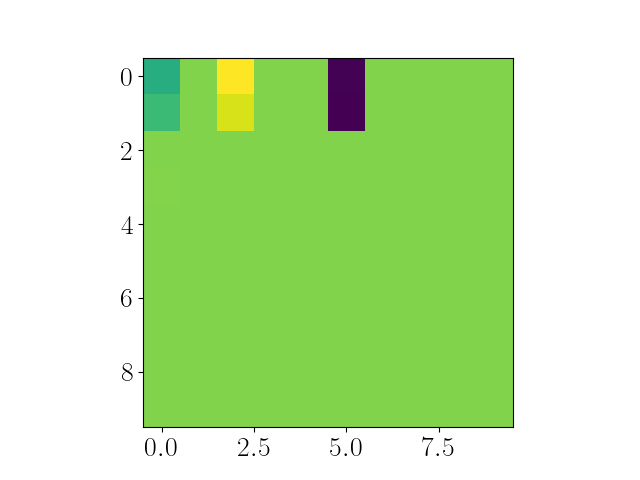

In [11]:
plt.figure()
plt.imshow(transmission_matrices[: , : , 1])

In [106]:
T00 = np.array([[1 , 2 ],[3 , 4]])
T01 = np.array([[5 , 6 ],[7 , 8]])
np.block([[T00 , T01] , [np.zeros((2,2)) , np.zeros((2 , 2))] ])

array([[1., 2., 5., 6.],
       [3., 4., 7., 8.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [110]:
1/np.sqrt(np.array([1 , 4 , 9 , 16]))

array([1.        , 0.5       , 0.33333333, 0.25      ])